In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

### Import related libraries

In [3]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [4]:
train_labels_path = "../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"

In [5]:
labels = pd.read_csv(train_labels_path)

In [6]:
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [7]:
labels.shape

(30227, 6)

In [8]:
labels.drop_duplicates("patientId")

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,666.0,418.0,186.0,223.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0


In [9]:
labels = labels.drop_duplicates("patientId")
labels.shape

(26684, 6)

In [10]:
ROOT_PATH = Path("../input/rsna-pneumonia-detection-challenge/stage_2_train_images")
SAVE_PATH = Path("/root/Processed")

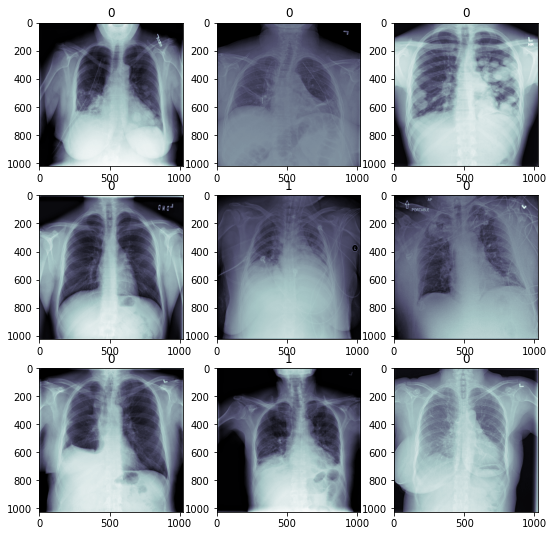

In [11]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
c = 0

for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

### Dicom Reading & Effective storage

X-ray --> DICOM format 

Normalizasyon içi her bir görüntüdeki piksellerin ortalam ve standart sapması hesaplandı

Ardından oluşturulan görüntüler ikili etiketlerine göre iki ayrı klasörde saklanır:
* 0:  zatürre belirtisi gösteren X-Ray görüntüleri
* 1:  zatürre belirtisi göstermeyen X-Ray görüntüleri

In [12]:
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    
    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.read_file(dcm_path).pixel_array / 255
    
    # Let's use a shape of 224x224
    # In order to use less space when storing the image we convert it to float16
    dcm_array = cv2.resize(dcm, (224,224)).astype(np.float16)
    
    # Retrieve the corresponding label
    label = labels.Target.iloc[c]
    
    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val"
    
    current_save_path = SAVE_PATH/train_or_val/str(label)  # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array) # Save the array in the corresponding directory
    
    ### updating the sums and sums_squared just for training data
    normalizer = 224*224  # Normalize sum of image
    if train_or_val == "train":    # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array**2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [13]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - (mean**2))

In [14]:
# we will use mean and std later to normalize the dataset 
mean, std

(0.4903962485384803, 0.24795070634161256)

### Training

In [15]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [17]:
train_tranforms = transforms.Compose([
    transforms.ToTensor(),                     # Convert numpy array to tensor
    transforms.Normalize(0.49, 0.248),         # Use calculated mean and std before
    transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9,1.1)),   # Data Augmentation
    transforms.RandomResizedCrop((224,224), scale=(0.35,1))    #RandomResizedCrops which applies a random crop of the 
])                                                            #image and resizes it to the original image size (224x224)

### validation data is not augmented
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49,0.248)
])

In [18]:
train_data = torchvision.datasets.DatasetFolder("/root/Processed/train", loader=load_file,
                                                extensions="npy", transform=train_tranforms)
val_data = torchvision.datasets.DatasetFolder("/root/Processed/val", loader=load_file,
                                             extensions="npy", transform=val_transform)

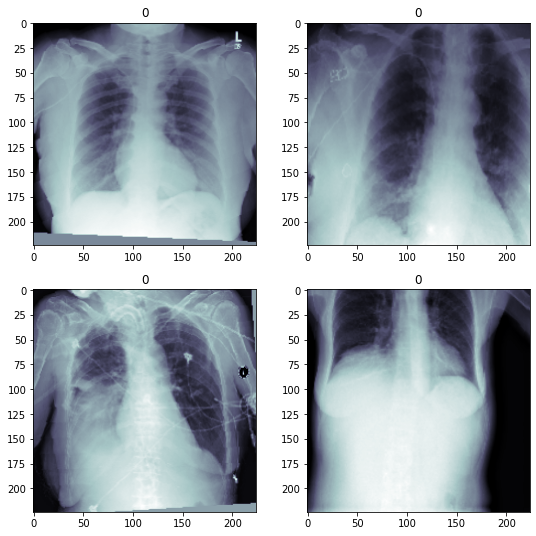

In [19]:
# Let's see some augmented train images
fig, axis = plt.subplots(2,2, figsize=(9,9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0,24000)
        x_ray, label = train_data[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(label)

In [20]:
batch_size = 128
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
# shuffle=True --> Imagine a case that at first fit 1000 X-ray images that do not show signs of pneumonia to model  or vice versa

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)
# shuffle=False --> don't want to shuffle data in order to get a deterministic evaluation.

In [21]:
print(f"There are {len(train_data)} train images and {len(val_data)} val images")

There are 24000 train images and 2684 val images


In [22]:
# distribution of the  train labels
np.unique(train_data.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

In [23]:
# distribution of the  validation labels
np.unique(val_data.targets, return_counts=True)

(array([0, 1]), array([2079,  605]))

In [24]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        
        super().__init__()
        
        self.model = torchvision.models.resnet18()  # don't need to create a model from scratch
        
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
    
    # prediction 
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()   # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]   # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)   # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train ACC", self.train_acc.compute())
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()   # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]   # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)   # Compute the loss
        
        # Log validation metrics
        self.log("Validation Loss", loss)
        self.log("Step Validation ACC", self.val_acc(torch.sigmoid(pred), label.int()))
    
    def validation_epoch_end(self, outs):
        self.log("Validation ACC", self.val_acc.compute())
        
    def configure_optimizers(self):
        
        return [self.optimizer]

In [26]:
model = PneumoniaModel()

In [27]:
# Create the checkpoint callback (validation accuracy en yüksek olan 10 modeli kaydediyorum.)
checkpoint_callback = ModelCheckpoint(monitor="Validation ACC", save_top_k=10, mode="max")

In [28]:
gpus = 1
trainer = pl.Trainer(gpus=gpus, logger= TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback, max_epochs=20)

In [29]:
trainer.fit(model, train_loader, val_loader)

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Evaluation

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = PneumoniaModel.load_from_checkpoint("../input/weights/weights/weights_1.ckpt") # without weighted loss
model.eval()
model.to(device);

Loss = sum(loss(h(x[i]), y[i])) / M

In [31]:
#Compute prediction on the complete validation set and store predictions and labels
preds = []
labels = []
with torch.no_grad():
    for data, label in tqdm(val_data):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [32]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")


# high recall means that the model rarely misses a case of pneumonia. However, the low precision means that
# images without pneumonia are also classified as pneumonic. 

# confusion matrix show us 1936 images were correctly classified into class "0", in contrast 334 images were
# correctly classified as pneumonic. 271 pneumonias missed. however, 143 images were classfied incorrectly
# classified into class "1". 

# FN ratio is high. so that the recall score is low

Val Accuracy: 0.8457525968551636
Val Precision: 0.7002096176147461
Val Recall: 0.5520660877227783
Confusion Matrix:
 tensor([[1936.,  143.],
        [ 271.,  334.]])


In [33]:
# recall --> TP / (TP + FN)
334/(334+271)

0.5520661157024793

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = PneumoniaModel.load_from_checkpoint("../input/weights/weights/weights_3.ckpt") # with weighted loss
model.eval()
model.to(device);

Weighted Loss = sum(loss(h(x[i]), y[i]) * w[i] ) / sum(w[i])

In [35]:
preds = []
labels = []
with torch.no_grad():
    for data, label in tqdm(val_data):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [36]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")

# confusion matrix show us 1537 images were correctly classified into class "0", in contrast 517 images were
# correctly classified as pneumonic. 88 pneumonias missed. however, 542 images were classfied incorrectly
# classified into class "1". 

# Whether it's such a result can be considered good. 
# Low FN ratio and high recall score

Val Accuracy: 0.7652757167816162
Val Precision: 0.48819640278816223
Val Recall: 0.8545454740524292
Confusion Matrix:
 tensor([[1537.,  542.],
        [  88.,  517.]])


In [37]:
517 / (88 + 517)

0.8545454545454545

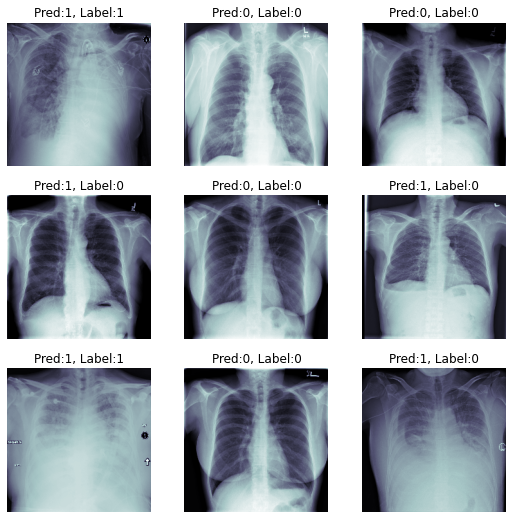

In [38]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_data[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")

### Interpretability

In [39]:
%matplotlib notebook
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [40]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [41]:
val_transforms = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(0.49, 0.248),
])

val_dataset = torchvision.datasets.DatasetFolder("/root/Processed/val/", loader=load_file, extensions="npy", transform=val_transforms)

In [43]:
# resneti tekrar inceleyelim
temp_model = torchvision.models.resnet18()
temp_model;

In [44]:
temp_model.children()

<generator object Module.children at 0x7fa498cfc2d0>

In [48]:
list(temp_model.children());

In [46]:
list(temp_model.children())[:-2]  # get all layers up to avgpool

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [47]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [49]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        # Extract the feature map
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])
        
    def forward(self, data):
        
        # Compute feature map
        feature_map = self.feature_map(data)
        
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1,1))
        
        # Flatten the output into a 512 element vector
        avg_output_flattened = torch.flatten(avg_pool_output)
        
        # Compute prediction
        pred = self.model.fc(avg_output_flattened)
        return pred, feature_map

In [50]:
model = PneumoniaModel.load_from_checkpoint("../input/weights/weights/weights_3.ckpt", strict=False)
model.eval();

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:206: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'feature_map.5.0.bn1.weight', 'fe

In [51]:
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    features = features.reshape(512,49)  # (512, 7, 7)
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    
    cam = torch.matmul(weight, features)  # The key idea of Cam is to multiply the output of the last convolutional layer
                                          # with the weights of the subsequent fully connected layer.
    
    cam_img = cam.reshape(7,7).cpu()
    return cam_img, torch.sigmoid(pred)

In [52]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224,224))[0]
    
    fig, axis = plt.subplots(1,2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred>0.5)

### Demo

In [53]:
img = val_dataset[-32][0]   # Select a subject
activation_map, pred = cam(model, img)  # Compute the Class activation map given the subject

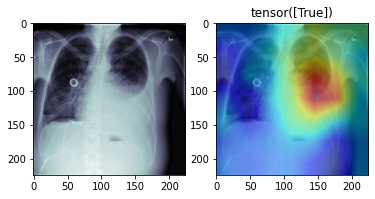

In [54]:
%matplotlib inline
visualize(img, activation_map, pred)

In [ ]:
### The heatmap focuses on the area which shows signs of pneumonia